## Data Generation

Shannon Gallagher Computational Physics Final Spring 2020 (PHY325). 

The cells below contain the code I used for data generation for my neural network. From the initialization of the percolation lattice to saving the different data.

As part of my project to transform a 2d cluster grid into a neural network to model percolation, this jupyter notebook focuses on the construction of the 2d grid. 

So to create this grid one must understand two components:
1. Computational: How to create and tune a 2d cluster grid
2. Physical: What is the physical basis of this percolation model




### References

I am basing my 2d grid model off of the Ising model in Giordano's Computational Physics as well as this example from the scipython website: https://scipython.com/blog/the-forest-fire-model/.


Giordano N. 1997. "Computational Physics." Upper Sadie River, NJ: Pretence-Hall inc. p. 315-328

Forest Fire Model [Online]. The Forest-fire model. https://scipython.com/blog/the-forest-fire-model/ [10 May 2020].



In [12]:
#standard import cell

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
import random

#### Animation
The cell below is a space which I used to experiment with the water percolation model. The cell below creates an animation after being run. As of the time this is written I have not yet been able to find a method to save the animations with my laptop due to software issues, however there is a commented out command to save with ffmpeg for anyone who has it installed and opertaional. 

The inital lattice for this project was 100 x 100, which meant that there were 10000 cells in the lattice. This was very computationally taxing, for reasons that will become clear upon neural network implementation. So I reduced the size to 50x50 which is 1/4 the number of cells. The smaller lattice exhibited the same percolation behavior (threshold/ qualitative motion patterns) so I moved forward with the 50 x 50 lattice. 

For those who have greated compuational power, or more patience, the 100 x 100 data is saved in this folder.

<IPython.core.display.Javascript object>


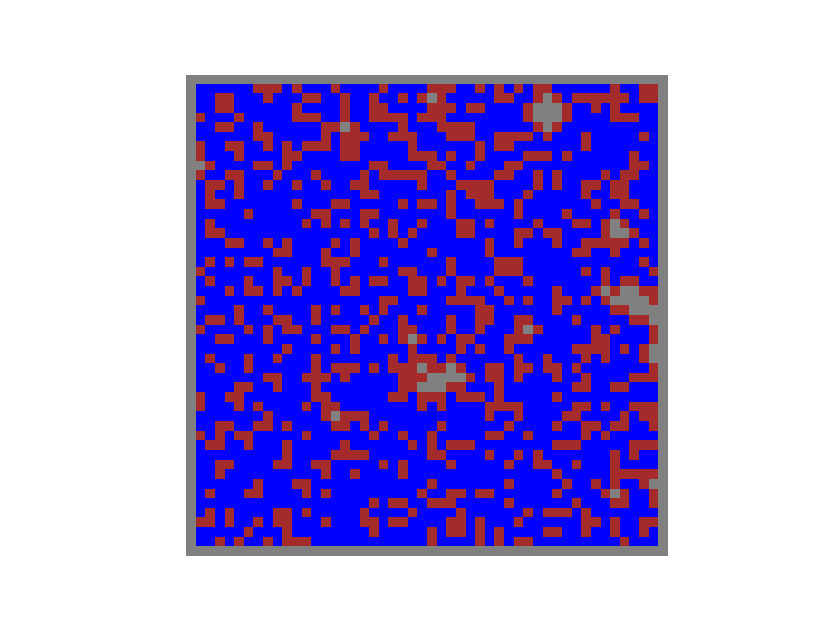

In [16]:
# I will modify the code from the scipython.com forest fire model
#to represent my percolation model

%matplotlib notebook


EMPTY,ROCK,WATER = 0, 1, 2
# Colours for visualization: brown for ROCK, white for EMPTY and blue
# for WATER. Note that for the colormap to work, this list and the bounds list
# must be one larger than the number of different values in the array.

#I initially chose shades of brown for water accepting and water blocking soil, however those
#colors were less easily separated visually



source= 0 #1,2,3,4

#Source 0 is above
#Source 1 the left
#Source 2 is beneath
#Source 3 is the right
#Source 4 is the center



colors_list = ['gray', 'brown','blue']
cmap = colors.ListedColormap(colors_list)
bounds = [0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

def iterate(X):
    """Iterate the ground according to the percolation rules."""


    
    # In this model we will only count the four nearest neighbors, above, below, left, and right
    # this assumes that water cannot move between the crack of two rock neighbors 
    neighborhood = ((-1,0), (0,-1), (0, 1), (1,0))
    X1 = np.zeros((ny, nx))
    
    # The boundary of the ground is always empty, so only consider cells
    # indexed from 1 to nx-2, 1 to ny-2
    
    for ix in range(1,nx-1):
        for iy in range(1,ny-1):
            
            #if the cell is rock or water or empty before it will stay the same
            if X[iy,ix] == WATER: 
                X1[iy,ix] = WATER
            if X[iy,ix] == ROCK: 
                X1[iy,ix] = ROCK
            if X[iy,ix] == EMPTY:
                X1[iy,ix] = EMPTY
                        #unless the cell is empty next to water
                        #in which case it will become a water cell
                for dx,dy in neighborhood:
                    if X[iy+dy,ix+dx] == WATER:
                        X1[iy,ix] = WATER
                        break
    return X1

# The initial fraction of the forest occupied by rocks.
rock_fraction = 0.30

# ground section size (number of cells in x and y directions).
nx, ny = 50, 50


# Initialize the ground section grid.
X  = np.zeros((ny, nx))

X[1:ny-1, 1:nx-1] = np.random.randint(0, 2, size=(ny-2, nx-2))

#initializes the rocks
X[1:ny-1, 1:nx-1] = np.random.random(size=(ny-2, nx-2)) < rock_fraction

if source == 0: #above
    X[0,0:nx-1] = 2
    
if source == 1: #left
    X[0:ny-1,0] = 2
    
if source == 2: #beneath
    X[0:ny-1,0] = 2
    
if source == 3: #right
    X[0:ny-1,ny-1] = 2
    
if source == 4: #center
    midy= ny//2
    midx= nx//2
    X[midy,midx] = 2

fig = plt.figure(figsize=(25/3, 6.25))
ax = fig.add_subplot(111)
ax.set_axis_off()
im = ax.imshow(X, cmap=cmap, )#norm=norm)#, interpolation='nearest')

# The animation function: called to produce a frame for each generation.
def animate(i):
    im.set_data(animate.X)
    animate.X = iterate(animate.X)
# Bind our grid to the identifier X in the animate function's namespace.
animate.X = X




# Interval between frames (ms).
interval = 100
anim = animation.FuncAnimation(fig, animate, interval=interval,frames=150,repeat=False,save_count=150)
#anim.save('test.mp4')

#mywriter = animation.FFMpegWriter()
#anim.save('mymovie.mp4',writer=mywriter)
plt.show()


### Data + Fruitful function

The function below unlike the function above
* cannot make animations (yet)
* is fruitful and returns data

In [17]:
def percolate_sim(width,height,rock_fraction,percent_return=False,source=0):
    """This function simulates the percolation of groundwater through porous soil. 
    This simulation does not take gravity into account, and assumes that the 
    water source is at sufficient pressure that if an available square is next to the water
    the water will fill it.
    
    Code is based off/inspired by:
    https://scipython.com/blog/the-forest-fire-model/
    
    
    parameters:
    (width,height): tuple of integers representing the width and height of the soil section 
    respectively
    rock_fraction: float <1 that represents the percentage of rock in the soil which cannot
    absorb water
    data_return: boolean which when true returns the initial conditions in an nx by 
    ny matrix, as well as the percentage of empty sections filled with water
    source: integer between 0 and 4, correspoding to different water source loactions
    which correspond respectively to above left, below, right, and center.
    
    
    
    returns(optional, see percent_return flag)
    X_start: (ny*nx, 1) of initial conditions(0 = empty, 1 = rock, 2 = water)
    perc_vector: 1*2 numpy array
    percentage submerged: float between 0 and 1, rounded to the nearest .1 for analysis 
    purposes
    
    """
    %matplotlib notebook
    #so any animation will be generated in the notebook
    
    EMPTY,ROCK,WATER = 0, 1, 2
    # Colours for visualization: brown for ROCK, gray for EMPTY and blue
    # for WATER. 
    
    #sets up colormap
    colors_list = ['gray', 'brown','blue']
    cmap = colors.ListedColormap(colors_list)
    bounds = [0,1,2,3]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    nx =width
    ny= height
    
    # Initialize the ground section grid.
    X  = np.zeros((ny, nx))
    
    #initializes the rocks
    X[1:ny-1, 1:nx-1] = np.random.randint(0, 2, size=(ny-2, nx-2))
    X[1:ny-1, 1:nx-1] = np.random.random(size=(ny-2, nx-2)) < rock_fraction
    
    #Source 0 is above
    #Source 1 the left
    #Source 2 is beneath
    #Source 3 is the right
    #Source 4 is the center

    if source == 0: #above
        X[0,0:nx-1] = 2
    
    if source == 1: #left
        X[0:ny-1,0] = 2
    
    if source == 2: #beneath
        X[0:ny-1,0] = 2
    
    if source == 3: #right
        X[0:ny-1,ny-1] = 2
    
    if source == 4: #center
        midy= ny//2
        midx= nx//2
        X[midy,midx] = 2
        
    X_start = X
    #saves the initial conditions
    
    #-----------------------------------------------------------------------------#
    #creates the figure
    #fig = plt.figure(figsize=(25/3, 6.25))
    #ax = fig.add_subplot(111)
    #ax.set_axis_off()
    #im = ax.imshow(X, cmap=cmap, )#norm=norm)#, interpolation='nearest')
        
    #animate.X=X
    #if x is referenced, it is x animated
    
    # Interval between frames (ms).
    #interval = 100
    #anim = animation.FuncAnimation(fig, animate, interval=interval)#,frames=200)
    #plt.show()
    #-----------------------------------------------------------------------------#
    
    #okay so now I will just create the data returns while I have not yet gotten the animation
    #to work in the subroutine.
    
    for i in range(200):
        X= iterate(X)
        #iterates x 200 times
        
    
    if percent_return:
        #now to find the percentage submerged
        final_data = np.reshape(X, (nx*ny, 1))
        

        #removing the rocks from the data
        np.delete(final_data, np.where(final_data == 1), axis=0)

        #average remaining values
        almost_percentage=np.mean(final_data)
        percentage= almost_percentage/2 #since water is worth 2 not 1

        percentage= round(percentage,1) #rounds to the nearest percentage


        return X_start,percentage 
    else:
        final_data=X
        if source == 0: #above
            check_area = final_data[ny-2:,:]#if the water has made it within 3 cells of the
                #other side
            #print(check_area.shape)
        elif source == 1: #left
            check_area = final_data[:,:2]
        elif source == 2: #beneath
            check_area = final_data[:2,:]
        elif source == 3: #right
            check_area=final_data[:,nx-2:]
        elif source == 4:
            final_data[2:ny-2,2:nx-2]=0 #removes all but boarders
            check_area = final_data
        else: 
            print("other sources not working currently")
        #checks for percolation
        perc_vector = np.zeros((2,1))
        if 2 in check_area:
            perc_vector[1]=1 #0% unpercolated and 100% percolated
            #[0,1]
        else:
            perc_vector[0]=1 #100% unpercolated and 0% percolated
            #[1,0]
        #changed to vector instead of boolean
        #to have two nodes on final layer instead of just one
        
            
    #I still need as a list for the network!        
    X_start_layer=np.reshape(X_start, (nx*ny, 1))

    return X_start_layer, perc_vector
    

In [19]:
# this is a test to make sure that we are getting the expected value from the function

values = percolate_sim(100,100,.2,percent_return=False,source=0)
print(values[1])

[[1.]
 [0.]]


In [22]:
number_of_samples=10 #set sample number
all_rocks=[.1,.2,.3,.4,.5,.6,.7,.8,.9]
extreme_rocks=[.9,.8,.1,.2]
critical_rocks=[.3,.4,.5,.6]
#types of rock fraction lists, change to your purpose


training_set = []
for i in range (number_of_samples):
    #print(i)
    rocks=random.choice(extreme_rocks) #extreme data
    training_set.append(percolate_sim(50,50,rocks,percent_return=False,source=0))
    
testing_set=[]
for i in range (number_of_samples):
    #print(i)
    rocks=random.choice(critical_rocks) #data near critical point
    testing_set.append(percolate_sim(50,50,rocks,percent_return=False,source=0))



    
    
    
#np.save('training.npy', training_set)
#np.save('testing.npy', testing_set)